In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set font size of plot elements\n",
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def noise_pow(ω, ω_c, κ, r, g, Q, Δ, nc, nT):
    """
    function for calculating the noise power spectrum per equation 2 in Kurt's paper
    :param ω:      frequency offset from the cavity frequency
    :param ω_c:    frequency of the cavity
    :param κ:      output coupling rate of cavity
    :param r:      effective cooling rate term
    :param g:      collective interaction between spins and cavity
    :param Q:      quality factor of cavity
    :param Δ:      detuning
    :param nc:     number of photons in the cold spin ensemble
    :param nT:     number of photons in the thermal mode
    :returns:      the noise power at ω
    """
    a = nc - nT
    num = κ * r * g ** 2
    den_b = ((r ** 2 / 4) + ω ** 2) * ((κ + ω_c / Q) ** 2 / 4 + (ω - Δ) ** 2)
    den_c = (r * (κ + ω_c / Q) / 2 - 2 * ω * (ω - Δ))

    return nT + a * num / (den_b + g ** 2 * den_c + g ** 4)

In [4]:
def mean_photons_cavity(κ, ω_c, Q, r, g, nT, nc):
    """
    function for calculating the steady state photon number in the cavity per equation 98 in Kurt's supplemental info document
    """
    num = (κ + ω_c / Q) * nT + r * g ** 2 / ((r/2)**2 + (r/2)*((κ+ω_c / Q) / 2) + g ** 2) * nc
    den = (κ + ω_c / Q) + r * g ** 2 / ((r/2)**2 + (r/2)*((κ+ω_c / Q) / 2) + g ** 2)
    return num / den

## T = 77 K, Q = 10, 000

### Set up and miscellaneous testing

In [5]:
# Define parameters.  According to Ethan, Q = 10,000 @ T = 77 K and g_j = 1 Hz at minimum
κ = 0
ω = 0                                           
ωc = 2.87 * 2 * np.pi * 1e9        
hbar_ov_k = 7.639e-12   
Q = 1e4
T = 77
γ = ωc / Q 
P = 0.8

In [6]:
# Sweep over values of g now
g = np.logspace(4, 8, 1000)
r = g.copy()

In [7]:
# Calculate the number of photons
nc = 0.5 * (1 - P) / P
nT = (np.exp(hbar_ov_k * ωc / T) - 1) ** -1

In [8]:
nT

558.4752332974967

In [9]:
Np_v_g = noise_pow(ω, ωc, κ, r, g, Q, 0, nc, nT)
T_v_g = hbar_ov_k * ωc * 2 * np.pi / np.log(1 / Np_v_g + 1)
nbar_v_g = mean_photons_cavity(κ, ωc, Q, g, g, nT, nc)

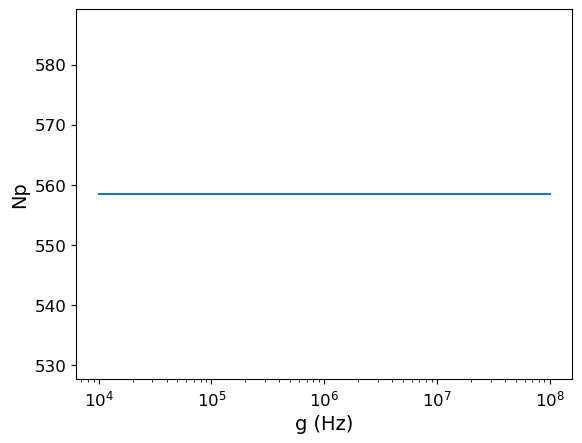

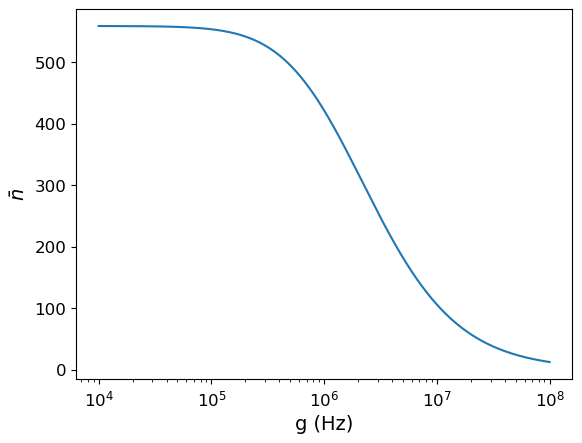

In [10]:
plt.figure(1)
plt.plot(g, Np_v_g)
plt.xlabel("g (Hz)")
plt.ylabel("Np")
plt.xscale('log')
plt.savefig("Np_v_g_κ=0_T=77K_P=0.8.png", format='png', dpi=300)

plt.figure(2)
plt.plot(g, nbar_v_g)
plt.xlabel("g (Hz)")
plt.ylabel("$\\bar{n}$")
plt.xscale('log')
plt.savefig("n_v_g_κ=0_T=77K_P=0.8.png", format='png', dpi=300)

Actually, according to Kurt's paper, there's two regimes for maximum cooling.  If
$8g^2 \leq r^2 + (\kappa + \gamma)^2$, the frequency at which the maximum occurs is 0 (i.e. the cavity frequency) and the maximum reduction is $\frac{2\kappa rg^2(n_T-n_c)}{[4g^2 + r(\kappa + \gamma)]^2}$.  If $8g^2 > r^2 + (\kappa + \gamma)^2$, the maximum occurs at $\omega^2 = g^2 - \frac{1}{8}[r^2 + (\kappa + \gamma)^2]$ and the maximum reduction is $\frac{64\kappa rg^2(n_c-n_T)}{(\gamma + \kappa + r)^2[16g^2-(\gamma+\kappa - r)^2]}$.  Here we're using $g = r$, so the condition is $7g^2 \leq (\kappa + \gamma)^2$ instead.

In [11]:
# so what is the flipping point for g?
g_crit = np.sqrt((κ + γ) ** 2 / 7)
print(g_crit)

681573.5763294188


Text(0, 0.5, 'Np')

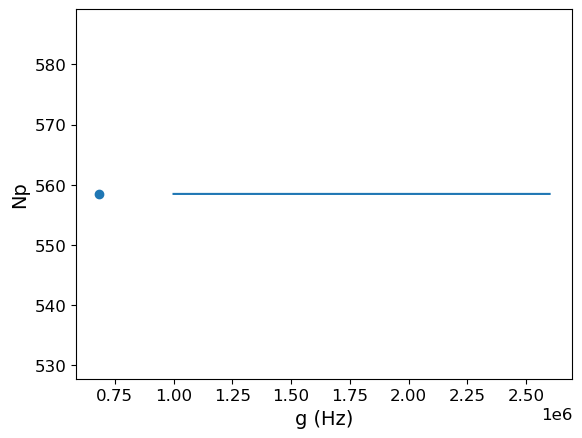

In [12]:
# Let's check around that point just to make sure we did it right.  
# Using ω = 0, we should see Np decrease until this point, then flip
g = np.linspace(1e6, 2.6e6, 1000000)
Np_v_g = noise_pow(ω, ωc, κ, g, g, Q, 0, nc, nT)
Np_crit = noise_pow(ω, ωc, κ, g_crit, g_crit, Q, 0, nc, nT)
plt.plot(g, Np_v_g)
plt.scatter(g_crit, Np_crit)
plt.xlabel("g (Hz)")
plt.ylabel("Np")

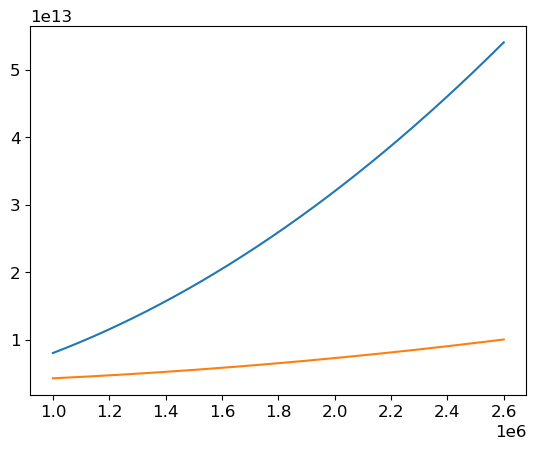

In [13]:
plt.plot(g, 8 * g ** 2)
plt.plot(g, g ** 2 + (κ + γ) ** 2)

In [14]:
# Not sure what's going on here, to be honest.  It doesn't seem that the predicted value of g actually corresponds to things flipping around

Text(0, 0.5, 'Np')

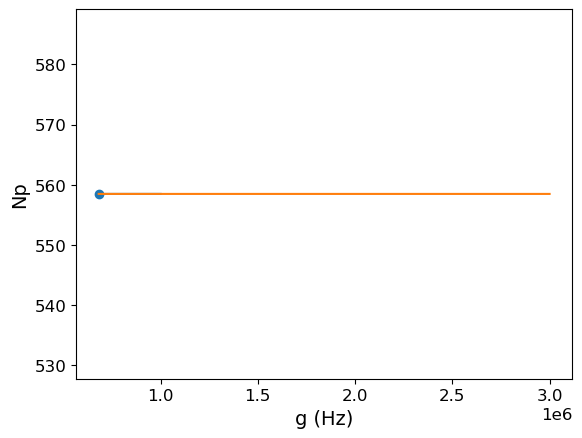

In [15]:
# Let's try stitching together around that point
g_bel = np.linspace(1e6, g_crit, 10000)
g_abo = np.linspace(g_crit, 3e6, 10000)
Np_bel = noise_pow(ω, ωc, κ, g_bel, g_bel, Q, 0, nc, nT)
ω_abo = g_abo ** 2 - (g_abo ** 2 + (κ + γ) ** 2) / 8
Np_abo = noise_pow(ω_abo, ωc, κ, g_abo, g_abo, Q, 0, nc, nT)
plt.plot(g_bel, Np_bel)
plt.scatter(g_crit, Np_crit)
plt.plot(g_abo, Np_abo)
plt.xlabel("g (Hz)")
plt.ylabel("Np")

In [16]:
# Well, that didn't work.  Not sure why

### Sweep over parameters

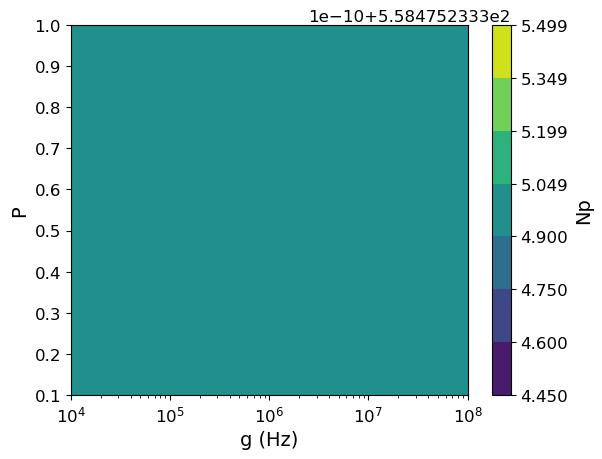

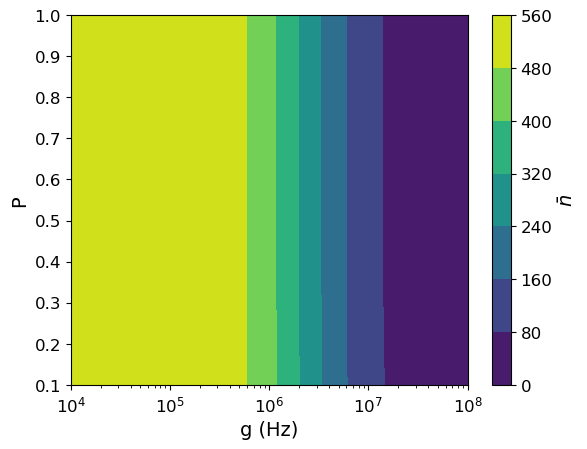

In [17]:
# Let's try sweeping over a couple of different parameters with g to see what we can find.  We'll keep Q fixed for now
# First let's do P
g = np.logspace(4, 8, 1000)
P_sweep = np.linspace(0.1, 1, 1000)
nc_sweep = 0.5 * (1 - P_sweep) / P_sweep

gm, ncm = np.meshgrid(g, nc_sweep)
Np_P_sweep = noise_pow(ω, ωc, κ, gm, gm, Q, 0, ncm, nT)
plt.figure(1)
plt.contourf(gm, 1 / (1 + 2 * ncm), Np_P_sweep)
plt.xlabel("g (Hz)")
plt.ylabel("P")
plt.xscale('log')
plt.colorbar(label='Np')
plt.savefig("Np_gP_sweep_κ=0_T=77K.png", format='png', dpi=300)

nbar_P_sweep = mean_photons_cavity(κ, ωc, Q, gm, gm, nT, ncm) 
plt.figure(2)
plt.contourf(gm, 1 / (1 + 2 * ncm), nbar_P_sweep)
plt.xlabel("g (Hz)")
plt.ylabel("P")
plt.xscale('log')
plt.colorbar(label='$\\bar{n}$')
plt.savefig("n_gP_sweep_κ=0_T=77K.png", format='png', dpi=300)

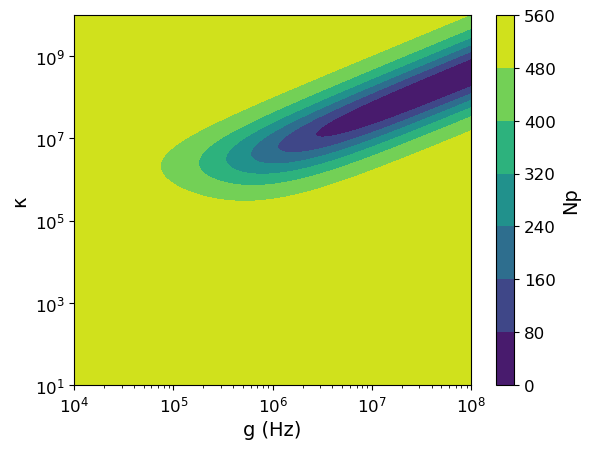

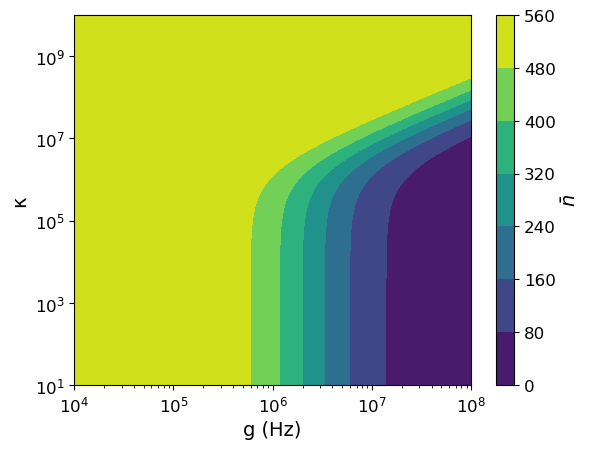

In [18]:
# Now let's do κ
g = np.logspace(4, 8, 1000)
κ_sweep = np.logspace(1, 10, 1000)

gm, κm = np.meshgrid(g, κ_sweep)
Np_κ_sweep = noise_pow(ω, ωc, κm, gm, gm, Q, 0, nc, nT)
plt.figure(1)
plt.contourf(gm, κm, Np_κ_sweep)
plt.xlabel("g (Hz)")
plt.ylabel("κ")
plt.yscale('log')
plt.xscale('log')
plt.colorbar(label='Np')
plt.savefig("Np_gκ_sweep_P=0.8_T=77K.png", format='png', dpi=300)

nbar_κ_sweep = mean_photons_cavity(κm, ωc, Q, gm, gm, nT, nc) 
plt.figure(2)
plt.contourf(gm, κm, nbar_κ_sweep)
plt.xlabel("g (Hz)")
plt.ylabel("κ")
plt.yscale('log')
plt.xscale('log')
plt.colorbar(label='$\\bar{n}$')
plt.savefig("n_gκ_sweep_P=0.8_T=77K.png", format='png', dpi=300)

## T = 5 K, Q = 25, 000

### Setup

In [19]:
# Now what if the initial temperature is 5 K?  According to Ethan, then Q = 25,000
κ = 0
ω = 0                                           
ωc = 2.87 * 2 * np.pi * 1e9        
hbar_ov_k = 7.639e-12   
Q = 2.5e4
T = 5
γ = ωc / Q 
P = 0.8

In [20]:
# Sweep over values of g now
g = np.logspace(4, 8, 1000)
r = g.copy()

In [21]:
# Calculate the number of photons
nc = 0.5 * (1 - P) / P
nT = (np.exp(hbar_ov_k * ωc / T) - 1) ** -1

In [22]:
Np_v_g = noise_pow(ω, ωc, κ, r, g, Q, 0, nc, nT)
T_v_g = hbar_ov_k * ωc * 2 * np.pi / np.log(1 / Np_v_g + 1)
nbar_v_g = mean_photons_cavity(κ, ωc, Q, g, g, nT, nc)

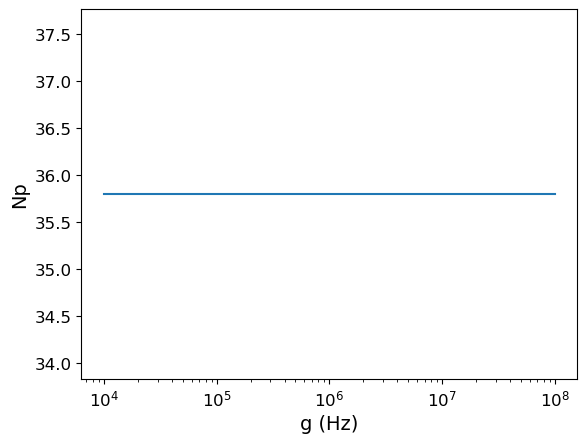

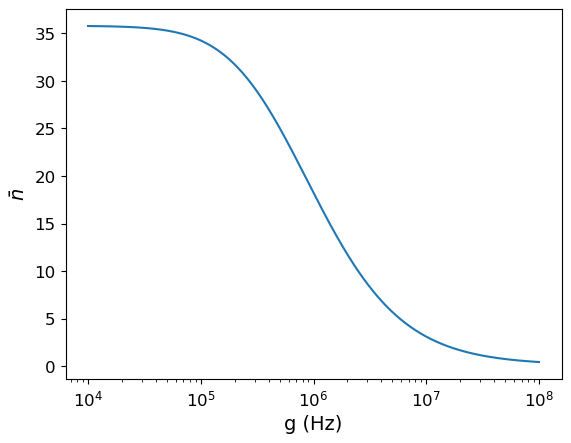

In [23]:
plt.figure(1)
plt.plot(g, Np_v_g)
plt.xlabel("g (Hz)")
plt.xscale('log')
plt.ylabel("Np")
plt.savefig("Np_v_g_κ=0_T=5K_P=0.8.png", format='png', dpi=300)

plt.figure(2)
plt.plot(g, nbar_v_g)
plt.xlabel("g (Hz)")
plt.xscale('log')
plt.ylabel("$\\bar{n}$")
plt.savefig("n_v_g_κ=0_T=5K_P=0.8.png", format='png', dpi=300)

### Sweep over parameters

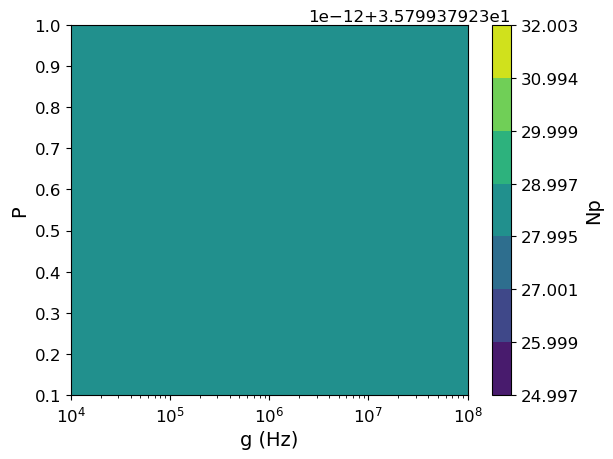

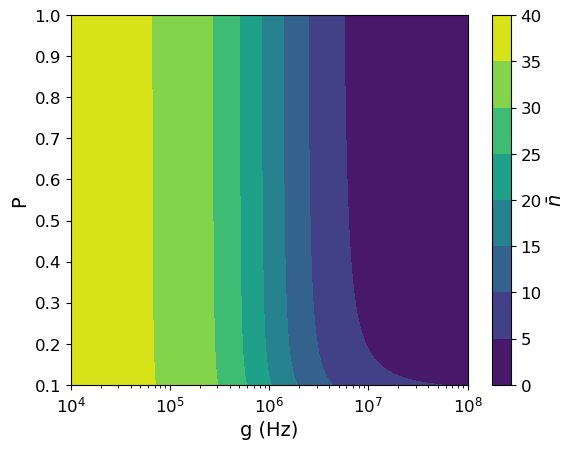

In [24]:
g = np.logspace(4, 8, 1000)
P_sweep = np.linspace(0.1, 1, 1000)
nc_sweep = 0.5 * (1 - P_sweep) / P_sweep

gm, ncm = np.meshgrid(g, nc_sweep)
Np_P_sweep = noise_pow(ω, ωc, κ, gm, gm, Q, 0, ncm, nT)
plt.figure(1)
plt.contourf(gm, 1 / (1 + 2 * ncm), Np_P_sweep)
plt.xlabel("g (Hz)")
plt.xscale("log")
plt.ylabel("P")
plt.colorbar(label='Np')
plt.savefig("Np_gP_sweep_κ=0_T=5K.png", format='png', dpi=300)

nbar_P_sweep = mean_photons_cavity(κ, ωc, Q, gm, gm, nT, ncm) 
plt.figure(2)
plt.contourf(gm, 1 / (1 + 2 * ncm), nbar_P_sweep)
plt.xlabel("g (Hz)")
plt.xscale("log")
plt.ylabel("P")
plt.colorbar(label='$\\bar{n}$')
plt.savefig("n_gP_sweep_κ=0_T=5K.png", format='png', dpi=300)

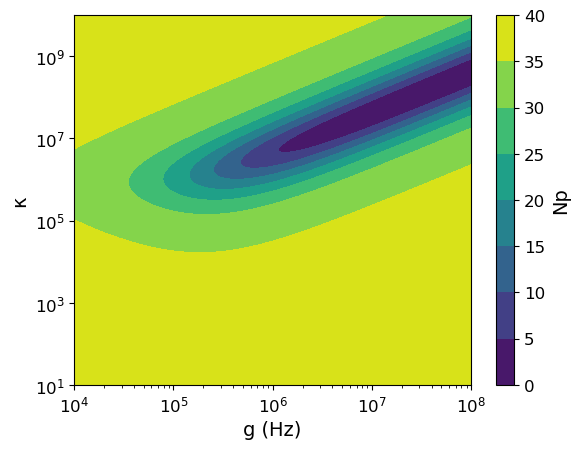

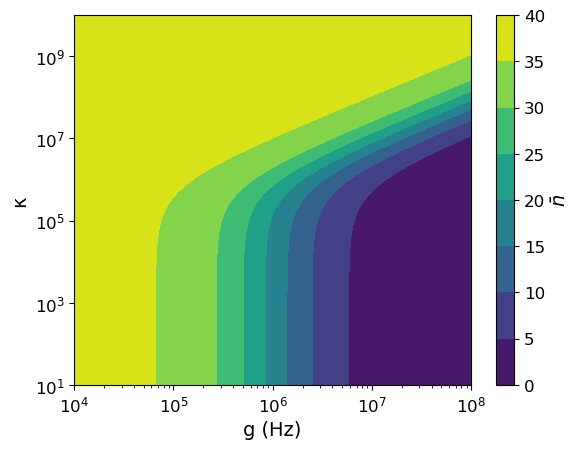

In [25]:
# Now let's do κ
g = np.logspace(4, 8, 1000)
κ_sweep = np.logspace(1, 10, 1000)

gm, κm = np.meshgrid(g, κ_sweep)
Np_κ_sweep = noise_pow(ω, ωc, κm, gm, gm, Q, 0, nc, nT)
plt.figure(1)
plt.contourf(gm, κm, Np_κ_sweep)
plt.xlabel("g (Hz)")
plt.ylabel("κ")
plt.yscale('log')
plt.xscale('log')
plt.colorbar(label='Np')
plt.savefig("Np_gκ_sweep_P=0.8_T=5K.png", format='png', dpi=300)

nbar_κ_sweep = mean_photons_cavity(κm, ωc, Q, gm, gm, nT, nc) 
plt.figure(2)
plt.contourf(gm, κm, nbar_κ_sweep)
plt.xlabel("g (Hz)")
plt.ylabel("κ")
plt.yscale('log')
plt.xscale('log')
plt.colorbar(label='$\\bar{n}$')
plt.savefig("n_gκ_sweep_P=0.8_T=5K.png", format='png', dpi=300)